Follow the article at [Cohort Analysis with Python](http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/).
I extracted the article's text and snippet of code [Python Pandas](http://pandas.pydata.org/) to make it a learning notebook. All credits goes to the author (Abdallah Mashashi).


## What is cohort analysis?

A cohort (see [Wikipedia cohort analysis](https://en.wikipedia.org/wiki/Cohort_analysis) is a group of users who share something in common, be it their sign-up date, first purchase month, birth date, acquisition channel, etc. Cohort analysis is the method by which these groups are tracked over time, helping you spot trends, understand repeat behaviors (purchases, engagement, amount spent, etc.), and monitor your customer and revenue retention.

It’s common for cohorts to be created based on a customer’s first usage of the platform, where "usage" is dependent on your business’ key metrics. For Uber or Lyft, usage would be booking a trip through one of their apps. For GrubHub, it’s ordering some food. For AirBnB, it’s booking a stay.

With these companies, a purchase is at their core, be it taking a trip or ordering dinner — their revenues are tied to their users’ purchase behavior.

In others, a purchase is not central to the business model and the business is more interested in "engagement" with the platform. Facebook and Twitter are examples of this - are you visiting their sites every day? Are you performing some action on them - maybe a "like" on Facebook or a "favorite" on a tweet?1

When building a cohort analysis, it’s important to consider the relationship between the event or interaction you’re tracking and its relationship to your business model.


## Why is it valuable?

Cohort analysis can be helpful when it comes to understanding your business’ health and "stickiness" - the loyalty of your customers. Stickiness is critical since [it’s far cheaper and easier to keep a current customer than to acquire a new one](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers). For startups, it’s also a key indicator of [product-market fit](https://en.wikipedia.org/wiki/Product/market_fit).

Additionally, your product evolves over time. New features are added and removed, the design changes, etc. Observing individual groups over time is a starting point to understanding how these changes affect user behavior.

It’s also a good way to visualize your user retention/churn as well as formulating a basic understanding of their lifetime value.

# 0. Get the data
The Excel file used in the article is [here](http://dmanalytics.org/wp-content/uploads/2014/10/chapter-12-relay-foods.xlsx)

The sample data set is pretty standard purchase data with IDs for the order and user, as well as the order date and purchase amount.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline
#df = pd.read_excel('/Users/gjreda/Dropbox/datasets/relay-foods.xlsx')
#df.head()


In [20]:
# Pandas has a method to read directy from Excel document. But it didn't work well with this Excel.
# So I exported into CSV the active sheet.
import pandas as pd
# Add asset from file system
df = pd.read_csv('../datasets/thanh-relay-foods.csv')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,1/11/09,47,$50.67,TRQKD,2,1/12/09
1,278,1/20/09,47,$26.60,4HH2S,3,1/20/09
2,294,2/3/09,47,$38.71,3TRDC,2,2/4/09
3,301,2/6/09,47,$53.38,NGAZJ,2,2/9/09
4,302,2/6/09,47,$14.28,FFYHD,2,2/9/09


# 1. Create a period column based on the OrderDate

Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of our users. Therefore, we don't want granular OrderDate data (right now).

In [21]:
# The original snippet of code doesn't work with the error
# 'str' object has no attribute 'strftime'
# df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))

# I then use the cnversion of string to date
# (Also apply to PickupDate)
from datetime import datetime
df.OrderDate=pd.to_datetime(df.OrderDate)
df.PickupDate=pd.to_datetime(df.PickupDate)
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,$50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,$26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,$38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,$53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,$14.28,FFYHD,2,2009-02-09,2009-02


In [22]:
df.dtypes

OrderId                  int64
OrderDate       datetime64[ns]
UserId                   int64
TotalCharges            object
CommonId                object
PupId                    int64
PickupDate      datetime64[ns]
OrderPeriod             object
dtype: object

# 2. Determine the user's cohort group (based on their first order)

Create a new column called CohortGroup, which is the year and month in which the user's first purchase occurred.

In [33]:
df.set_index('UserId', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head(100)

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01
5,47,321,2009-02-17,29.50,HA5R3,3,2009-02-17,2009-02,2009-01
6,47,333,2009-02-23,18.91,RSXQG,2,2009-02-23,2009-02,2009-01
7,47,341,2009-03-01,64.41,KHBDJ,3,2009-03-03,2009-03,2009-01
8,47,353,2009-03-09,18.03,T7SUN,3,2009-03-10,2009-03,2009-01
9,47,373,2009-03-17,25.55,KMF5X,3,2009-03-17,2009-03,2009-01


# 3. Rollup data by CohortGroup & OrderPeriod

Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within the month (OrderPeriod).

**Note that the TotalCharges has the dollar sign which needs to be removed before we can apply aggregation function (e.g. SUM).**

In [35]:
df['TotalCharges'] = (df['TotalCharges'].replace( '[\$,)]','', regex=True )
                         .replace( '[(]','-',   regex=True ).astype(float))
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head(300)


TotalOrders  TotalUsers  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01               30          22       1850.26
            2009-02               25           8       1351.07
            2009-03               26          10       1357.36
            2009-04               28           9       1604.50
            2009-05               26          10       1575.63
            2009-06               26           8       1384.84
            2009-07               24           8       1750.84
            2009-08               21           7       1426.59
            2009-09               24           7       1964.29
            2009-10               13           7        860.33
            2009-11               21           7       1821.82
            2009-12               22           8       2152.14
            2010-01               25          11       2084.23
            2010-02               19           7       2068.79
            2010-03               12           6       1504.34
2009-02     2009-02               15          15        666.31
            2009-03                8           3        501.61
            2009-04               10           5        968.78
            2009-05                2           1         53.36
            2009-06                9           4        758.52
            2009-07               11           4        667.10
            2009-08                6           4        314.18
            2009-09               12           5        567.51
            2009-10                7           5        328.28
            2009-11                6           4        738.93
            2009-12                5           3        263.19
            2010-01                5           3        550.01
            2010-02                9           5        734.77
2009-03     2009-03               18          13        806.31
            2009-04                6           4        463.80
...                              ...         ...           ...
2009-08     2010-02               12           4       1596.00
            2010-03                5           4        478.77
2009-09     2009-09               44          37       1953.06
            2009-10               42          15       2433.30
            2009-11               28          14       1953.23
            2009-12               20           8       1371.37
            2010-01               29          13       2262.05
            2010-02               22           9       1842.95
            2010-03                9           8        688.69
2009-10     2009-10               70          54       3802.27
            2009-11               37          17       1957.89
            2009-12               27          12       2394.54
            2010-01               28          13       1952.06
            2010-02               30          13       1783.11
            2010-03                9           7        546.08
2009-11     2009-11              166         130       6738.61
            2009-12               71          32       5107.43
            2010-01               59          26       5046.83
            2010-02               64          29       3486.12
            2010-03               17          13        961.37
2009-12     2009-12               88          65       4571.70
            2010-01               39          17       2565.46
            2010-02               28          18       1785.81
            2010-03                8           7        534.10
2010-01     2010-01              156          95       9677.95
            2010-02              101          50       8453.11
            2010-03               31          26       2238.66
2010-02     2010-02              139         100       7374.77
            2010-03               19          19        945.97
2010-03     2010-03               26          24       1099.56

[119 rows x 3 columns]

# 4. Label the CohortPeriod for each CohortGroup

We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their lifetime.

In [34]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(500)

OrderPeriod  TotalOrders  TotalUsers  TotalCharges  \
CohortGroup CohortPeriod                                                      
2009-01     1                2009-01           30          22       1850.26   
            2                2009-02           25           8       1351.07   
            3                2009-03           26          10       1357.36   
            4                2009-04           28           9       1604.50   
            5                2009-05           26          10       1575.63   
            6                2009-06           26           8       1384.84   
            7                2009-07           24           8       1750.84   
            8                2009-08           21           7       1426.59   
            9                2009-09           24           7       1964.29   
            10               2009-10           13           7        860.33   
            11               2009-11           21           7       1821.82   
            12               2009-12           22           8       2152.14   
            13               2010-01           25          11       2084.23   
            14               2010-02           19           7       2068.79   
            15               2010-03           12           6       1504.34   
2009-02     1                2009-02           15          15        666.31   
            2                2009-03            8           3        501.61   
            3                2009-04           10           5        968.78   
            4                2009-05            2           1         53.36   
            5                2009-06            9           4        758.52   
            6                2009-07           11           4        667.10   
            7                2009-08            6           4        314.18   
            8                2009-09           12           5        567.51   
            9                2009-10            7           5        328.28   
            10               2009-11            6           4        738.93   
            11               2009-12            5           3        263.19   
            12               2010-01            5           3        550.01   
            13               2010-02            9           5        734.77   
2009-03     1                2009-03           18          13        806.31   
            2                2009-04            6           4        463.80   
...                              ...          ...         ...           ...   
2009-08     7                2010-02           12           4       1596.00   
            8                2010-03            5           4        478.77   
2009-09     1                2009-09           44          37       1953.06   
            2                2009-10           42          15       2433.30   
            3                2009-11           28          14       1953.23   
            4                2009-12           20           8       1371.37   
            5                2010-01           29          13       2262.05   
            6                2010-02           22           9       1842.95   
            7                2010-03            9           8        688.69   
2009-10     1                2009-10           70          54       3802.27   
            2                2009-11           37          17       1957.89   
            3                2009-12           27          12       2394.54   
            4                2010-01           28          13       1952.06   
            5                2010-02           30          13       1783.11   
            6                2010-03            9           7        546.08   
2009-11     1                2009-11          166         130       6738.61   
            2                2009-12           71          32       5107.43   
            3                2010-01           59          26       5046.83

# 5. Make sure we did all that right

Let's test data points from the original DataFrame with their corresponding values in the new cohortsDataFrame to make sure all our data transformations worked as expected. As long as none of these raise an exception, we're good.

In [26]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
y = cohorts.ix[('2009-01', '2009-01')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-01', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-05', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

# I got all these warnings
### /opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
### .ix is deprecated. Please use
### .loc for label based indexing or
### .iloc for positional indexing

### See the documentation here:
### http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


# 6. User Retention by Cohort Group

We want to look at the percentage change of each CohortGroup over time -- not the absolute change.

To do this, we'll first need to create a [pandas Series](pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) containing each CohortGroup and its size.

In [27]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

Now, we'll need to divide the TotalUsers values in cohorts by cohort_group_size. Since DataFrame operations are performed based on the indices of the objects, we'll use unstack on our cohortsDataFrame to create a matrix where each column represents a CohortGroup and each row is the CohortPeriod corresponding to that group.

To illustrate what unstack does, recall the first five TotalUsers values:

In [28]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

And here's what they look like when we unstack the CohortGroup level from the index:

In [29]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


Now, we can utilize [broadcasting](http://pandas.pydata.org/pandas-docs/stable/basics.html) to divide each column by the corresponding cohort_group_size.

The resulting DataFrame, user_retention, contains the percentage of users from the cohort purchasing within the given period. For instance, 38.4% of users in the 2009-03 purchased again in month 3 (which would be May 2009).

In [30]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first purchase, meaning everyone in the cohort purchased in month 1.

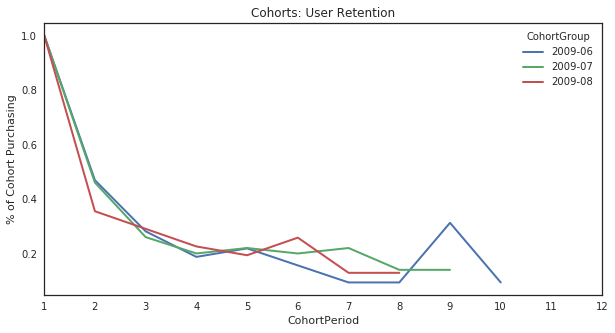

In [31]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

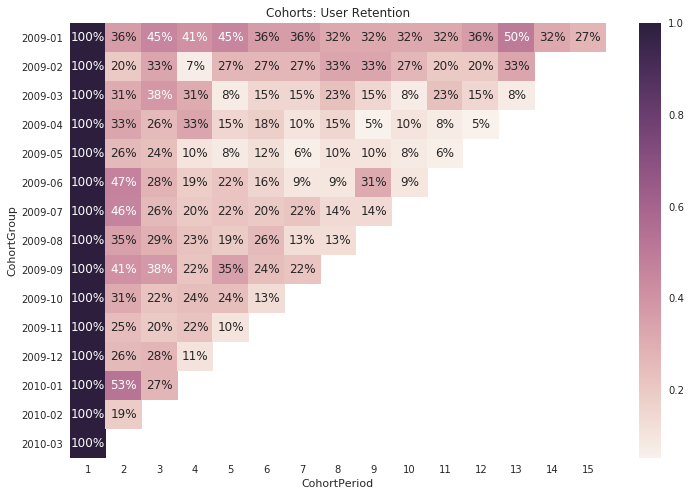

In [32]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

# I got warning
### /opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
###  (prop.get_family(), self.defaultFamily[fontext]))

Unsurprisingly, we can see from the above chart that fewer users tend to purchase as time goes on.

However, we can also see that the 2009-01 cohort is the strongest, which enables us to ask targeted questions about this cohort compared to others -- what other attributes (besides first purchase month) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? Did they take advantage of a promotion at sign-up? The answers to these questions would inform future marketing and product efforts.

# 7. Further work

User retention is only one way of using cohorts to look at your business — we could have also looked at revenue retention. That is, the percentage of each cohort’s month 1 revenue returning in subsequent periods. User retention is important, but we shouldn’t lose sight of the revenue each cohort is bringing in (and how much of it is returning).

For our **DigitalSuccess team**, further work could be making this sample into a simple tool allow our team members to
* Input data
* Select column to create Cohorts
* Output the visualization

**Note for Macbook Pro users who use DSX Desktop**. It's painful to find your own notebooks. I found them located on mine at ~/Library/Application\ Support/ibm-dsx-desktop/user-home/999/DSX_Projects/Thanh-Cohort/jupyter/Cohort-Learning.ipynb which means
* The path to your DSX Projects is **~/Library/Application\ Support/ibm-dsx-desktop/user-home/999/DSX_Projects**
* The project name is **Thanh-Cohort**
* The notebook is **Jupyter** (because you could use Zeppelin)
* The notebook name is **Cohort-Learning.ipynb**